<a href="https://colab.research.google.com/github/ForhanShahriarFahim/Artificial-Intelligence-Lab/blob/master/MNIST_Classifier_Augmentation_(Part_2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Date: 1 June,2024


### Import Necessary Libraries

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report

### Display Images

In [ ]:
def display_images(original, augmented, title):
    plt.figure(figsize=(15, 6))

    for i in range(8):
        plt.subplot(2, 8, i + 1)
        plt.imshow(original[i].reshape(28, 28), cmap='gray')
        plt.title("Original")
        plt.axis('off')

        plt.subplot(2, 8, i + 9)
        plt.imshow(augmented[i].reshape(28, 28), cmap='gray')
        plt.title("Augmented")
        plt.axis('off')

    plt.suptitle(title)
    plt.show()


### Load and Process the MNIST Data

In [ ]:
# Load MNIST data
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Normalize the images
train_images = train_images.reshape((60000, 28, 28, 1)).astype('float32') / 255
test_images = test_images.reshape((10000, 28, 28, 1)).astype('float32') / 255

# # One-hot encode the labels
train_labels = to_categorical(train_labels, 10)
test_labels = to_categorical(test_labels, 10)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


### Define Augmentation Functions

In [ ]:
# Augmentation functions
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=False
)

def photometric_augmentation(image):
    threshold_value = 0.5
    image = tf.where(image > threshold_value, 1.0, 0.0)
    image = tf.image.random_brightness(image, max_delta=0.5)
    image = tf.image.random_contrast(image, lower=0.5, upper=0.8)
    return image

# Define MixUp function
def mixup(data, labels, alpha=0.3):
    num_samples = data.shape[0]
    data_mixup = np.zeros_like(data)
    labels_mixup = np.zeros_like(labels)

    for i in range(num_samples):
        index = np.random.randint(num_samples)
        lambda_param = np.random.beta(alpha, alpha)
        data_mixup[i] = lambda_param * data[i] + (1 - lambda_param) * data[index]
        labels_mixup[i] = lambda_param * labels[i] + (1 - lambda_param) * labels[index]
    return data_mixup, labels_mixup


def cutmix(data, labels, alpha=0.3):
    num_samples = data.shape[0]

    data_cutmix = np.empty_like(data)
    labels_cutmix = np.empty_like(labels)

    for i in range(num_samples):
        index = np.random.randint(num_samples)
        rx, ry = np.random.randint(0, data.shape[1]), np.random.randint(0, data.shape[2])

        lambda_param = np.random.beta(alpha, alpha)
        rw, rh = int(data.shape[1] * np.sqrt(1 - lambda_param)), int(data.shape[2] * np.sqrt(1 - lambda_param))

        x1, x2 = np.clip(rx - rw // 2, 0, data.shape[1]), np.clip(rx + rw // 2, 0, data.shape[1])
        y1, y2 = np.clip(ry - rh // 2, 0, data.shape[2]), np.clip(ry + rh // 2, 0, data.shape[2])

        # Copy the original image
        data_cutmix[i] = data[i]
        # Replace the pixels in the cutout region with pixels from the shuffled data
        data_cutmix[i, x1:x2, y1:y2, :] = data[index, x1:x2, y1:y2, :]
        lambda_param = 1 - (rw * rh) / (data.shape[1] * data.shape[2])
        labels_cutmix[i] = lambda_param * labels[i] + (1 - lambda_param) * labels[index]

    return data_cutmix, labels_cutmix


### Apply Augmentations and Display Images

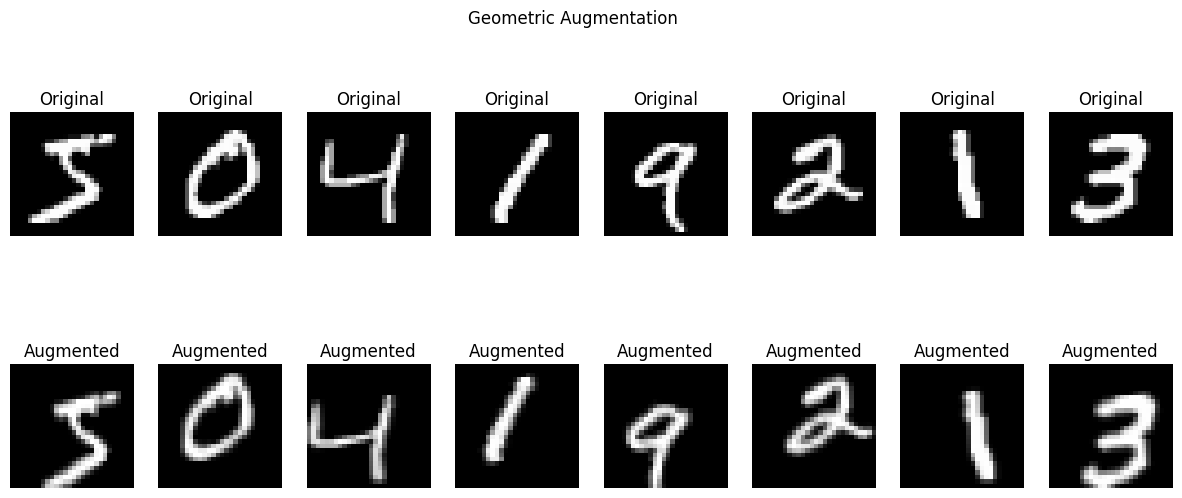

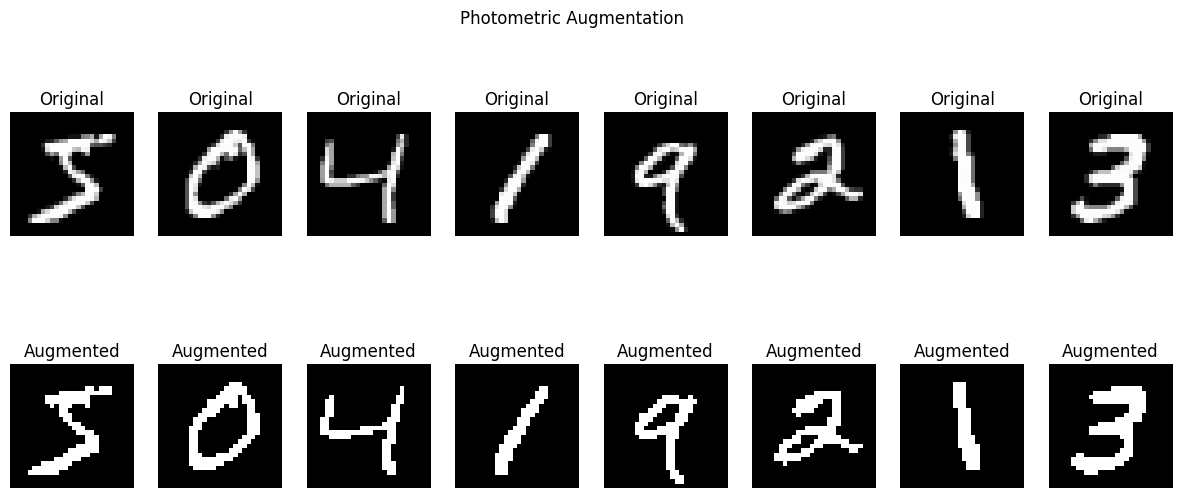

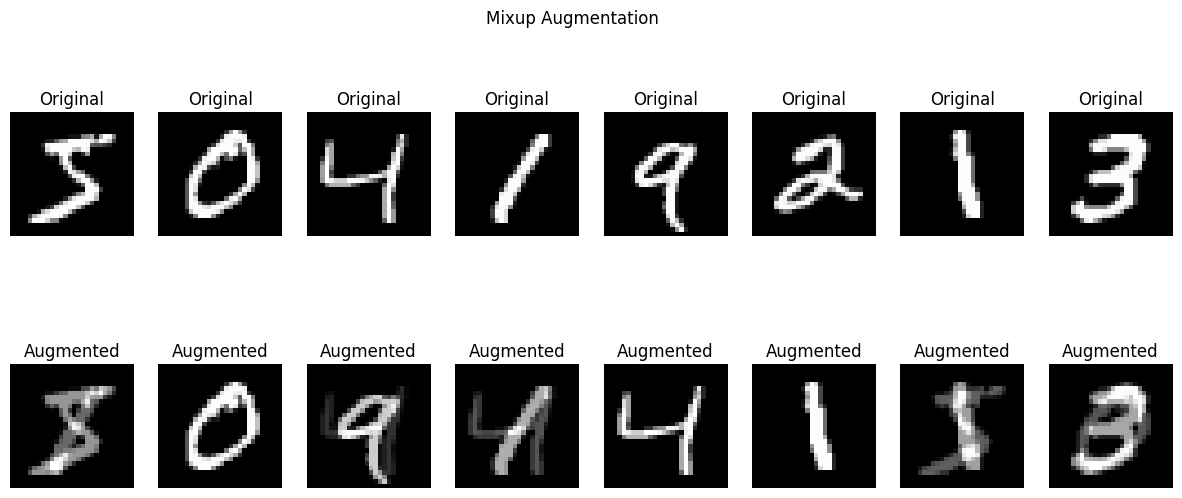

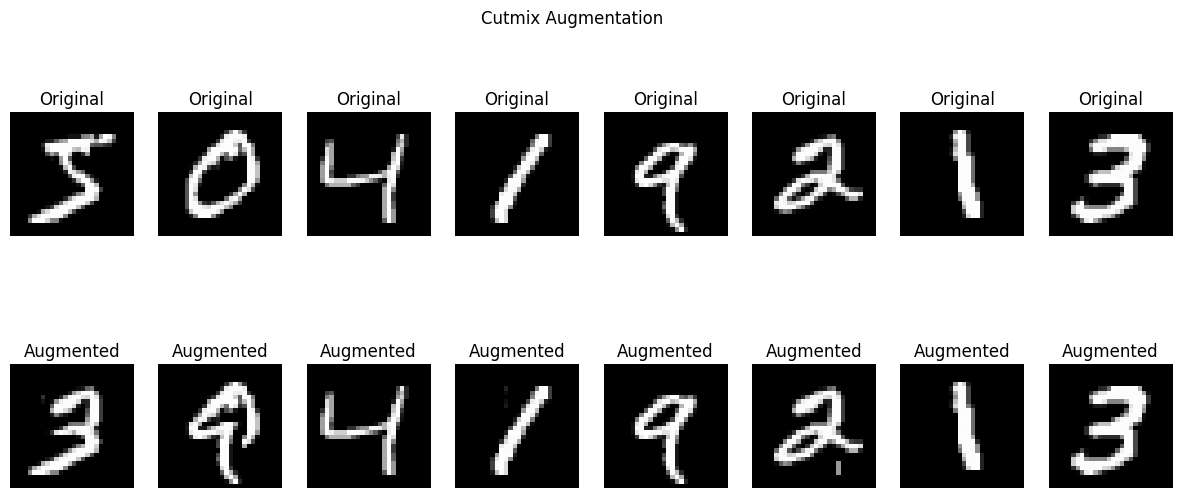

In [ ]:
num_samples = 8
sample_images = train_images[:num_samples]

# Geometric Augmentation
augmented_geo = np.array([datagen.random_transform(img) for img in sample_images])
display_images(sample_images, augmented_geo, 'Geometric Augmentation')

# Photometric Augmentation
augmented_photo = np.array([photometric_augmentation(img) for img in sample_images])
display_images(sample_images, augmented_photo, 'Photometric Augmentation')

# Mixup Augmentation
augmented_mixup, _ = mixup(sample_images, train_labels[:num_samples])
display_images(sample_images, augmented_mixup, 'Mixup Augmentation')

# Cutmix Augmentation
augmented_cutmix, _ = cutmix(sample_images, train_labels[:num_samples])
display_images(sample_images, augmented_cutmix, 'Cutmix Augmentation')

In [ ]:
# Geometric Augmentation
geo_augmented_images = np.array([datagen.random_transform(img) for img in train_images])
geo_augmented_labels = train_labels.copy()

photo_augmented_images = np.array([photometric_augmentation(img) for img in train_images])
photo_augmented_labels = train_labels.copy()
mixup_augmented_images, mixup_augmented_labels  = mixup(train_images, train_labels)

cutmix_augmented_images, cutmix_augmented_labels = cutmix(train_images, train_labels)
augmented_train_images = np.concatenate([
    train_images,
    geo_augmented_images,
    photo_augmented_images,
    mixup_augmented_images,
    cutmix_augmented_images
])

augmented_train_labels = np.concatenate([
    train_labels,
    geo_augmented_labels,
    photo_augmented_labels,
    mixup_augmented_labels,
    cutmix_augmented_labels
])


In [ ]:
# Round floating-point labels to integers
augmented_train_labels = np.round(augmented_train_labels).astype(int)
print(augmented_train_labels.shape)

(300000, 10)


In [ ]:
# Shuffle the data by zipping and then unzipping
combined = list(zip(augmented_train_images, augmented_train_labels))
np.random.shuffle(combined)
shuffled_augmented_train_images, shuffled_augmented_train_labels = zip(*combined)

# Convert back to numpy arrays
augmented_train_images = np.array(shuffled_augmented_train_images)
augmented_train_labels = np.array(shuffled_augmented_train_labels)

### Build Model

In [ ]:
# Model definition
def create_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1), padding='same'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

def create_model2():
    model = tf.keras.Sequential([
       tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
       tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(1, 1)),
       tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
       tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(1, 1)),
       tf.keras.layers.Flatten(),
       tf.keras.layers.Dense(64, activation='relu'),
       tf.keras.layers.Dense(10, activation='softmax')
  ])

  # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    model.summary()
    return model


In [ ]:
print(train_images.shape,train_labels.shape)

(60000, 28, 28, 1) (60000, 10)


### Fit Model

In [ ]:
cnn1 = create_model2()
history_cnn1 = cnn1.fit(train_images, train_labels, epochs=10, validation_split=0.2, batch_size = 64)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 22, 22, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 20, 20, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       1,638,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,657,930 (6.32 MB)

 Trainable params: 1,657,930 (6.32 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.9008 - loss: 0.3304 - val_accuracy: 0.9838 - val_loss: 0.0558
Epoch 2/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9852 - loss: 0.0452 - val_accuracy: 0.9883 - val_loss: 0.0396
Epoch 3/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9907 - loss: 0.0307 - val_accuracy: 0.9843 - val_loss: 0.0506
Epoch 4/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9935 - loss: 0.0208 - val_accuracy: 0.9912 - val_loss: 0.0338
Epoch 5/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9945 - loss: 0.0168 - val_accuracy: 0.9877 - val_loss: 0.0469
Epoch 6/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.9961 - loss: 0.0135 - val_accuracy: 0.9887 - val_loss: 0.0461
Epoch 7/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9950 - loss: 0.0143 - val_accuracy: 0.9887 - val_loss: 0.0456
Epoch 8/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9975 - loss: 0.0077 - val_accuracy: 0

### Plot

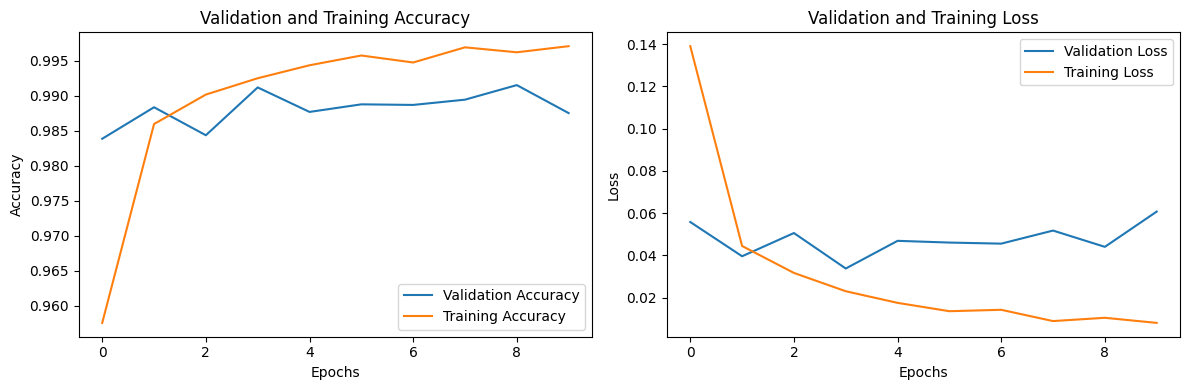

In [ ]:
# Plot the validation accuracy and loss
plt.figure(figsize=(12, 4))

# Plot validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history_cnn1.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history_cnn1.history['accuracy'], label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation and Training Accuracy')
plt.legend()

# Plot validation loss
plt.subplot(1, 2, 2)
plt.plot(history_cnn1.history['val_loss'], label='Validation Loss')
plt.plot(history_cnn1.history['loss'], label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation and Training Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Training cnn2 on augmented data
cnn2 = create_model2()
history_cnn2 = cnn2.fit(augmented_train_images, augmented_train_labels, epochs=10, validation_split=0.2, batch_size = 128)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 22, 22, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 20, 20, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 25600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │       1,638,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,657,930 (6.32 MB)

 Trainable params: 1,657,930 (6.32 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - accuracy: 0.8618 - loss: 0.4917 - val_accuracy: 0.9334 - val_loss: 0.2423
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - accuracy: 0.9375 - loss: 0.2220 - val_accuracy: 0.9381 - val_loss: 0.2175
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.9464 - loss: 0.1848 - val_accuracy: 0.9413 - val_loss: 0.2058
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9521 - loss: 0.1593 - val_accuracy: 0.9440 - val_loss: 0.1938
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9564 - loss: 0.1442 - val_accuracy: 0.9450 - val_loss: 0.2062
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - accuracy: 0.9610 - loss: 0.1251 - val_accuracy: 0.9445 - val_loss: 0.1982
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.9651 - loss: 0.1125 - val_accuracy: 0.9448 - val_loss: 0.2030
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.9687 - loss: 0

### Plot

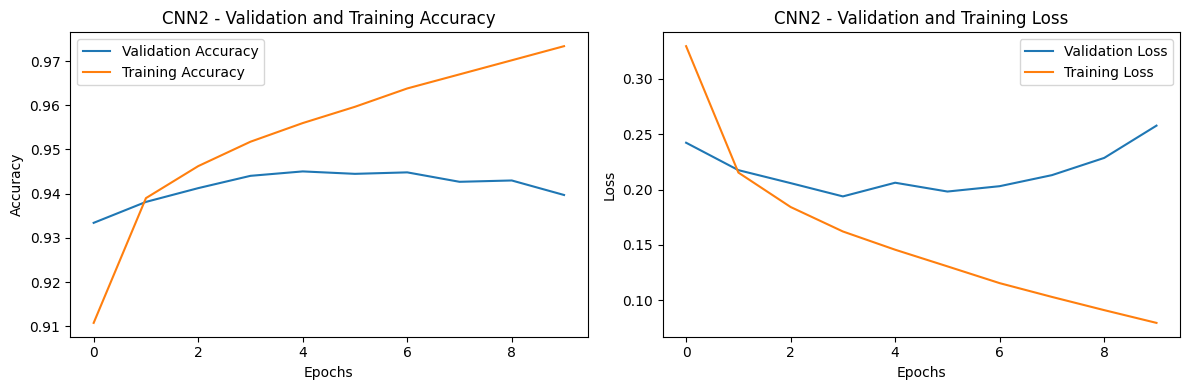

In [ ]:
plt.figure(figsize=(12, 4))

# Plot validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history_cnn2.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history_cnn2.history['accuracy'], label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('CNN2 - Validation and Training Accuracy')
plt.legend()

# Plot validation loss
plt.subplot(1, 2, 2)
plt.plot(history_cnn2.history['val_loss'], label='Validation Loss')
plt.plot(history_cnn2.history['loss'], label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('CNN2 - Validation and Training Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Augment the test data for evaluation
augmented_test_geo = np.array([datagen.random_transform(img) for img in test_images])
geo_augmented_test_labels = test_labels.copy()
augmented_test_photo = np.array([photometric_augmentation(img) for img in test_images])
photo_augmented_test_labels = test_labels.copy()
augmented_test_mixup, augmented_test_mixup_labels = mixup(test_images, test_labels)
augmented_test_cutmix, augmented_test_cutmix_labels = cutmix(test_images, test_labels)

augmented_test_images = np.concatenate([
    test_images,
    augmented_test_geo,
    augmented_test_photo,
    augmented_test_mixup,
    augmented_test_cutmix
])

augmented_test_labels = np.concatenate([
    test_labels,
    geo_augmented_test_labels,
    photo_augmented_test_labels,
    augmented_test_mixup_labels,
    augmented_test_cutmix_labels
])

# Round floating-point labels to integers
augmented_test_labels = np.round(augmented_test_labels).astype(int)


# Evaluate Both model using Original Data
- cnn1 - Original
- cnn2 - Augmented





In [ ]:
# Evaluate both models on normal test data
test_loss_cnn1, test_accuracy_cnn1 = cnn1.evaluate(test_images, test_labels)
test_loss_cnn2, test_accuracy_cnn2 = cnn2.evaluate(test_images, test_labels)
print(f'Test Loss (cnn1 - Original Train): {test_loss_cnn1}')
print(f'Test Accuracy (cnn1 - Original Train): {test_accuracy_cnn1}')
print(f'Test Loss (cnn2 - Augmented Train): {test_loss_cnn2}')
print(f'Test Accuracy (cnn2 - Augmented Train): {test_accuracy_cnn2}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9802 - loss: 0.0703
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9784 - loss: 0.0723
Test Loss (cnn1 - Original Train): 0.05530450493097305
Test Accuracy (cnn1 - Original Train): 0.9864000082015991
Test Loss (cnn2 - Augmented Train): 0.060765787959098816
Test Accuracy (cnn2 - Augmented Train): 0.982200026512146


# Evaluate Both model using Augmented Data

- cnn1 - Original
- cnn2 - Augmented




In [ ]:
# Evaluate both models on augmented test data
aug_test_loss_cnn1, aug_test_accuracy_cnn1 = cnn1.evaluate(augmented_test_images, augmented_test_labels)
aug_test_loss_cnn2, aug_test_accuracy_cnn2 = cnn2.evaluate(augmented_test_images, augmented_test_labels)
print(f'Augmented Test Loss (cnn1 - Original Train): {aug_test_loss_cnn1}')
print(f'Augmented Test Accuracy (cnn1 - Original Train): {aug_test_accuracy_cnn1}')
print(f'Augmented Test Loss (cnn2 - Augmented Train): {aug_test_loss_cnn2}')
print(f'Augmented Test Accuracy (cnn2 - Augmented Train): {aug_test_accuracy_cnn2}')

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9247 - loss: 0.3980
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9730 - loss: 0.1025
Augmented Test Loss (cnn1 - Original Train): 0.9901109337806702
Augmented Test Accuracy (cnn1 - Original Train): 0.8669000267982483
Augmented Test Loss (cnn2 - Augmented Train): 0.2714293301105499
Augmented Test Accuracy (cnn2 - Augmented Train): 0.9346399903297424


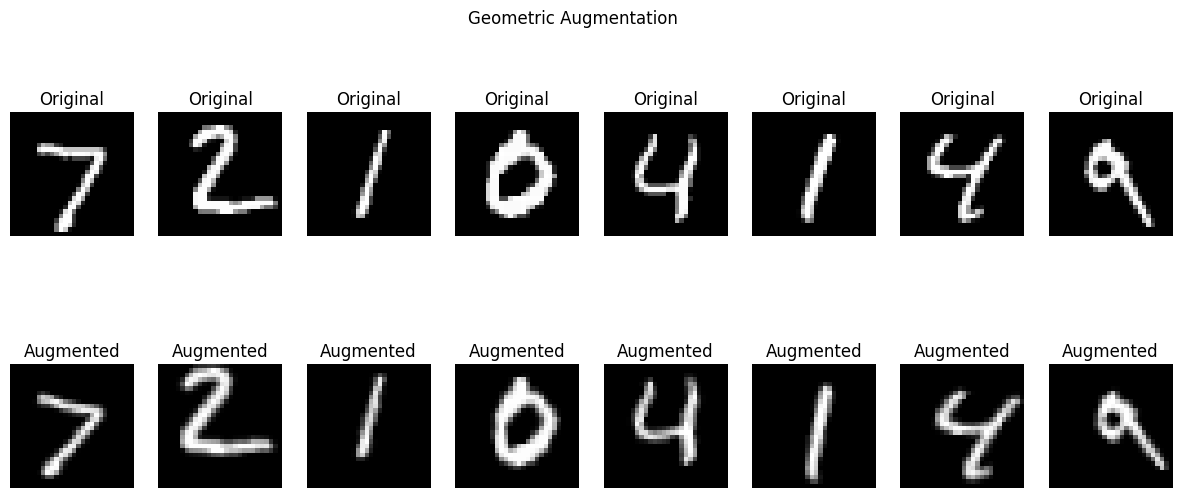

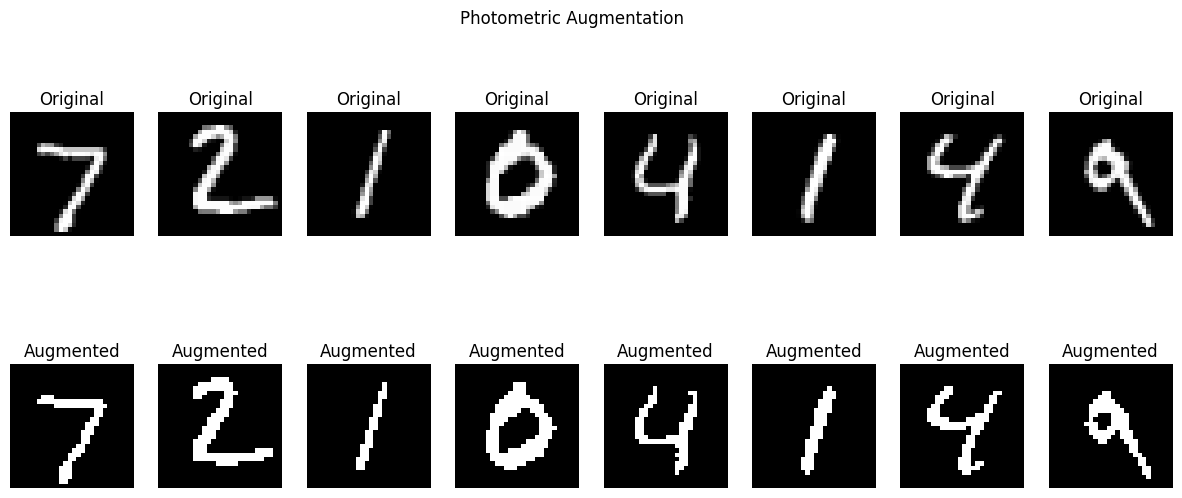

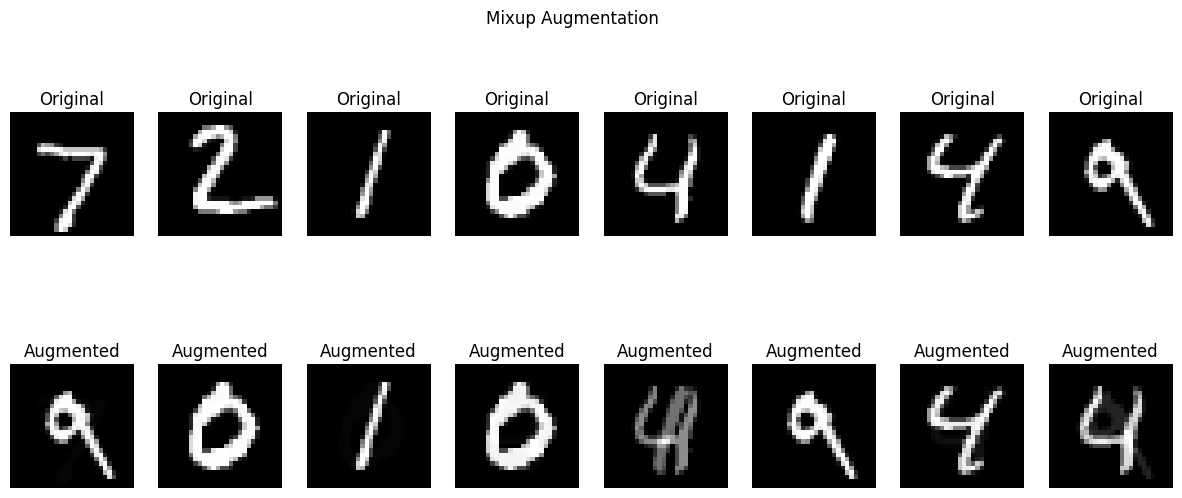

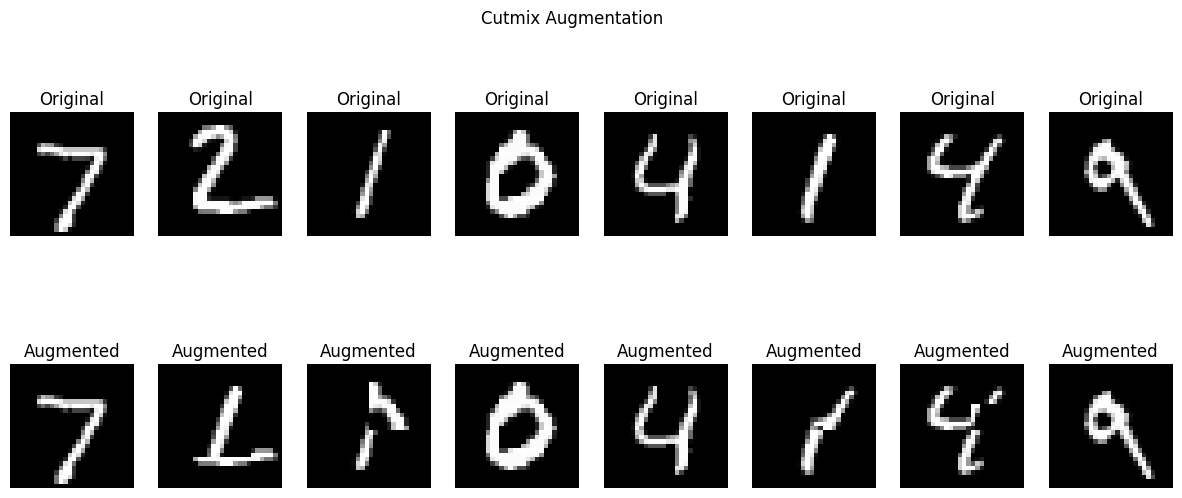

In [ ]:
num_samples = 8
sample_images = test_images[:num_samples]

# Geometric Augmentation
augmented_geo = np.array([datagen.random_transform(img) for img in sample_images])
display_images(sample_images, augmented_geo, 'Geometric Augmentation')

# Photometric Augmentation
augmented_photo = np.array([photometric_augmentation(img) for img in sample_images])
display_images(sample_images, augmented_photo, 'Photometric Augmentation')

# Mixup Augmentation
augmented_mixup, _ = mixup(sample_images, train_labels[:num_samples])
display_images(sample_images, augmented_mixup, 'Mixup Augmentation')

# Cutmix Augmentation
augmented_cutmix, _ = cutmix(sample_images, train_labels[:num_samples])
display_images(sample_images, augmented_cutmix, 'Cutmix Augmentation')

In [ ]:
def display_images_labels(original, augmented, title, original_labels=None, augmented_labels=None):

    print(title)
    print('-' * 40)

    for i in range(len(original)):
        print(f"Original Image {i + 1}:")
        print("Label:", np.argmax(original_labels[i]))
        print("One-hot Label:", original_labels[i])
        print()

        print(f"Augmented Image {i + 1}:")
        print("Label:", np.argmax(augmented_labels[i]))
        print("One-hot Label:", augmented_labels[i])
        print()

# Example usage
num_samples = 40
sample_images = train_images[:num_samples]

# Geometric Augmentation
augmented_geo = np.array([datagen.random_transform(img) for img in sample_images])
display_images_labels(sample_images, augmented_geo, 'Geometric Augmentation', train_labels[:num_samples], train_labels[:num_samples])

# Photometric Augmentation
augmented_photo = np.array([photometric_augmentation(img) for img in sample_images])
display_images_labels(sample_images, augmented_photo, 'Photometric Augmentation', train_labels[:num_samples], train_labels[:num_samples])

# Mixup Augmentation
augmented_mixup, _ = mixup(sample_images, train_labels[:num_samples])
display_images_labels(sample_images, augmented_mixup, 'Mixup Augmentation', train_labels[:num_samples], train_labels[:num_samples])

# Cutmix Augmentation
augmented_cutmix, _ = cutmix(sample_images, train_labels[:num_samples])
display_images_labels(sample_images, augmented_cutmix, 'Cutmix Augmentation', train_labels[:num_samples], train_labels[:num_samples])


Geometric Augmentation
----------------------------------------
Original Image 1:
Label: 5
One-hot Label: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]

Augmented Image 1:
Label: 5
One-hot Label: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]

Original Image 2:
Label: 0
One-hot Label: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

Augmented Image 2:
Label: 0
One-hot Label: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

Original Image 3:
Label: 4
One-hot Label: [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]

Augmented Image 3:
Label: 4
One-hot Label: [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]

Original Image 4:
Label: 1
One-hot Label: [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]

Augmented Image 4:
Label: 1
One-hot Label: [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]

Original Image 5:
Label: 9
One-hot Label: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]

Augmented Image 5:
Label: 9
One-hot Label: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]

Original Image 6:
Label: 2
One-hot Label: [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]

Augmented Image 6:
Label: 2
One-hot Label: [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]

Original Image 7:
Label: 1
One